In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Implementing Ornstein–Uhlenbeck process

In [ ]:
class OUActionNoise():
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + \
            self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        return x
    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)



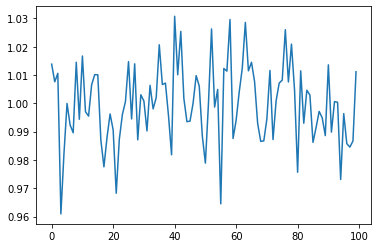

In [ ]:
N = 100
mu = np.array([1.2])
noise = OUActionNoise(mu=mu, x0=1)
vals = np.zeros(N)
for i in range(N):
    vals[i] = noise()
plt.plot(vals)

# Replay Buffer

In [ ]:
class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action , reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones


# Critic Network

In [ ]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions,
                 name, chkpt_dir='tmp/ddpg'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name + '_ddpg')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)
        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)

        self.q = nn.Linear(self.fc2_dims, 1)

        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f3 = 0.003
        self.q.weight.data.uniform_(-f3, f3)
        self.q.bias.data.uniform_(-f3, f3)

        f4 = 1./np.sqrt(self.action_value.weight.data.size()[0])
        self.action_value.weight.data.uniform_(-f4, f4)
        self.action_value.bias.data.uniform_(-f4, f4)

        self.optimizer = optim.Adam(self.parameters(), lr=beta,
                                    weight_decay=0.01)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)
        action_value = self.action_value(action)
        state_action_value = F.relu(T.add(state_value, action_value))
        state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))



# Actor Network

In [ ]:
class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions,
                name, chkpt_dir="tmp/ddpg"):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name + '_ddpg')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        self.mu = nn.Linear(self.fc2_dims, self.n_actions)

        # Initialization
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f3 = 0.003
        self.mu.weight.data.uniform_(-f3, f3)
        self.mu.bias.data.uniform_(-f3, f3)

        # Optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)

        # use gpu if gpu is available
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = T.tanh(self.mu(x))

        return x

    def save_checkpoint(self):
        print(' ... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print(' ... Loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))


# Agent class

In [ ]:
import torch.nn.functional as F

In [ ]:
class Agent():
    def __init__(self, alpha, beta, input_dims, tau, n_actions, gamma=0.99,
                 max_size=1000000, fc1_dims=400, fc2_dims=300,
                 batch_size=64):
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta

        # Defining memory
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)

        # Define noise class
        self.noise = OUActionNoise(mu=np.zeros(n_actions))

        # Define Actor and Critic Networks
        self.actor = ActorNetwork(alpha, input_dims, fc1_dims, fc2_dims,
                                  n_actions=n_actions, name='actor')
        self.critic = CriticNetwork(beta, input_dims, fc1_dims, fc2_dims,
                                    n_actions=n_actions, name='critic')

        # Define Target Actor and Target Critic Networks
        self.target_actor = ActorNetwork(alpha, input_dims, fc1_dims, fc2_dims,
                                  n_actions=n_actions, name='target_actor')
        self.target_critic = CriticNetwork(beta, input_dims, fc1_dims, fc2_dims,
                                    n_actions=n_actions, name='target_critic')

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        self.actor.eval()
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(state).to(self.actor.device)
        mu_prime = mu + T.tensor(self.noise(), dtype=T.float).to(self.actor.device)
        self.actor.train()

        return mu_prime.cpu().detach().numpy()[0]

    def remember(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        states, actions, rewards, states_, done = self.memory.sample_buffer(self.batch_size)

        states = T.tensor(states, dtype=T.float).to(self.actor.device)
        states_ = T.tensor(states_, dtype=T.float).to(self.actor.device)
        actions = T.tensor(actions, dtype=T.float).to(self.actor.device)
        rewards = T.tensor(rewards, dtype=T.float).to(self.actor.device)
        done = T.tensor(done).to(self.actor.device)

        target_actions = self.target_actor.forward(states_)
        critic_value_ = self.target_critic.forward(states_, target_actions)
        critic_value = self.critic.forward(states, actions)

        critic_value_[done] = 0.0
        critic_value_ = critic_value_.view(-1)

        target = rewards + self.gamma*critic_value_
        target = target.view(self.batch_size, 1)

        # Critic loss
        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        # Actor loss
        self.actor.optimizer.zero_grad()
        actor_loss = -self.critic.forward(states, self.actor.forward(states))
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_state_dict = dict(target_critic_params)
        target_actor_state_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                (1-tau)*target_critic_state_dict[name].clone()

        for name in actor_state_dict:
             actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                 (1-tau)*target_actor_state_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)
        self.target_actor.load_state_dict(actor_state_dict)
        #self.target_critic.load_state_dict(critic_state_dict, strict=False)
        #self.target_actor.load_state_dict(actor_state_dict, strict=False)


# Main Loop

In [ ]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    #plt.savefig(figure_file)

In [ ]:
!pip3 install box2d-py

In [ ]:
import gym

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


episode  0 score -78.2 average score -78.2
episode  1 score -1376.1 average score -727.1
episode  2 score -492.3 average score -648.9
episode  3 score -735.8 average score -670.6
episode  4 score -777.6 average score -692.0
episode  5 score -737.6 average score -699.6
episode  6 score -699.0 average score -699.5
episode  7 score -583.9 average score -685.1
episode  8 score -652.2 average score -681.4
episode  9 score -425.2 average score -655.8
episode  10 score -102.8 average score -605.5
episode  11 score -136.1 average score -566.4
episode  12 score -156.2 average score -534.8
episode  13 score -167.9 average score -508.6
episode  14 score -147.2 average score -484.5
episode  15 score -147.5 average score -463.5
episode  16 score -173.6 average score -446.4
episode  17 score -141.3 average score -429.5
episode  18 score -167.7 average score -415.7
episode  19 score -312.4 average score -410.5
episode  20 score -168.4 average score -399.0
episode  21 score -213.9 average score -390.6

FileNotFoundError: ignored

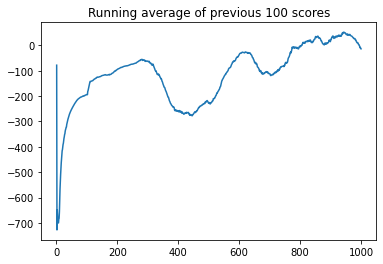

In [ ]:
env = gym.make('LunarLanderContinuous-v2')
agent = Agent(alpha=0.0001, beta=0.001,
              input_dims=env.observation_space.shape, tau=0.001,
              batch_size=64, fc1_dims=400, fc2_dims=300,
              n_actions=env.action_space.shape[0])
n_games = 1000
filename = 'LunarLander_alpha_' + str(agent.alpha) + '_beta_' + \
            str(agent.beta) + '_' + str(n_games) + '_games'
figure_file = 'plots/' + filename + '.png'
best_score = env.reward_range[0]
score_history = []
for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    agent.noise.reset()
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        agent.remember(observation, action, reward, observation_, done)
        agent.learn()
        score += reward
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        #agent.save_models()

    print('episode ', i, 'score %.1f' % score,
            'average score %.1f' % avg_score)
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, score_history, figure_file)


In [ ]:
import os

if os.path.exists('/tmp/ddpg/actor_ddpg') == False:
  os.mkdir('/tmp/ddpg/actor_ddpg')

os.chdir('/tmp/ddpg/actor_ddpg')
!pwd
!ls

In [ ]:
from google.colab import drive
drive.mount('/content/drive')